In [3]:
!nvidia-smi

Wed Dec  7 06:10:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    35W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.4 MB/s 
     |████████████████████████████████| 7.6 MB 43.5 MB/s 
     |████████████████████████████████| 182 kB 60.7 MB/s 


In [1]:
# importing required libraries
import requests
import json
import torch
import os
from tqdm import tqdm
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from transformers import BertForQuestionAnswering
from transformers import AdamW

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab,ocr]

# For Colab/linux based machines:
!wget https://dl.xpdfreader.com/xpdf-tools-linux-4.04.tar.gz
!tar -xvf xpdf-tools-linux-4.04.tar.gz && sudo cp xpdf-tools-linux-4.04/bin64/pdftotext /usr/local/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-yjyd1sf5/farm-haystack_5652df00d76f4510a1c26ef9052ee844
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-install-yjyd1sf5/farm-haystack_5652df00d76f4510a1c26ef9052ee844
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.1 MB 30.0 MB/s 
     |████████████████████████████████| 4.7 MB 63.0 MB/s 
     |████████████████████████████████| 10.7 MB 58.9 MB/s 
     |████████████████████████████████| 85 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 5.6 MB 54.5 MB/s 
     |████████████████████████████████| 16.5 MB 61.7 MB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
     |████████████████████████████████|

--2022-12-07 06:07:54--  https://dl.xpdfreader.com/xpdf-tools-linux-4.04.tar.gz
Resolving dl.xpdfreader.com (dl.xpdfreader.com)... 45.79.72.155
Connecting to dl.xpdfreader.com (dl.xpdfreader.com)|45.79.72.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23687259 (23M) [application/x-gzip]
Saving to: ‘xpdf-tools-linux-4.04.tar.gz’

xpdf-tools-linux-4. 100%[===================>]  22.59M  7.79MB/s    in 2.9s    

2022-12-07 06:07:58 (7.79 MB/s) - ‘xpdf-tools-linux-4.04.tar.gz’ saved [23687259/23687259]

xpdf-tools-linux-4.04/
xpdf-tools-linux-4.04/CHANGES
xpdf-tools-linux-4.04/COPYING3
xpdf-tools-linux-4.04/INSTALL
xpdf-tools-linux-4.04/ANNOUNCE
xpdf-tools-linux-4.04/bin64/
xpdf-tools-linux-4.04/bin64/pdftopng
xpdf-tools-linux-4.04/bin64/pdftohtml
xpdf-tools-linux-4.04/bin64/pdfinfo
xpdf-tools-linux-4.04/bin64/pdffonts
xpdf-tools-linux-4.04/bin64/pdfimages
xpdf-tools-linux-4.04/bin64/pdftotext
xpdf-tools-linux-4.04/bin64/pdftoppm
xpdf-tools-linux-4.04/bin64/pd

In [6]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 30.2 MB/s 
     |████████████████████████████████| 880 kB 46.3 MB/s 
     |████████████████████████████████| 132 kB 77.1 MB/s 
     |████████████████████████████████| 10.2 MB 52.2 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |████████████████████████████████| 140 kB 28.4 MB/s 
     |████████████████████████████████| 127 kB 63.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=34675b13dddfdc40f24acaf9dea51aca8be931caf1644ce60559e50bb805ed7c
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Performing Question Answering with a Fine-Tuned BERT

In [5]:
# We have training data built using Haystack Data Annotator [https://annotate.deepset.ai/index.html]
# This file has been saved in my Google Drive
with open('/content/drive/MyDrive/train-v1.json', 'rb') as f:
  merged= json.load(f)

In [6]:
print('Size of training dataset ' + str(len(merged['data'])))

Size of training dataset 120


In [7]:
# This file has been saved in my Google Drive
with open('/content/drive/MyDrive/dev-v1.json', 'rb') as f:
  val_data= json.load(f)

print('Size of validation dataset ' + str(len(val_data['data'])))

Size of validation dataset 30


In [8]:
from haystack.nodes import FARMReader
from haystack.utils import fetch_archive_from_http

### epochs = 1

In [9]:
reader = FARMReader(model_name_or_path="bert-large-uncased-whole-word-masking-finetuned-squad", use_gpu=True)
data_dir = "/content/drive/MyDrive"
reader.train(data_dir=data_dir, train_filename="merged_file.json", use_gpu=True, n_epochs=1, save_dir="devansh_model")


INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://docs.haystack.deepset.ai/docs/telemetry
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'bert-large-uncased-whole-word-masking-finetuned-squad' (Bert)


INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'bert-large-uncased-whole-word-masking-finetuned-squad' (Bert model) from model hub.


INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: /content/drive/MyDrive/merged_file.json 


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING DEV DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:No dev set is being loaded
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING TEST DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:No test set is being loaded
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:DATASETS SUMMARY
INFO:haystack.modeling.data_handler.data_silo:================
INFO:haystack.modeling.data_handler.data_silo:Examples in train: 525
INFO:haystack.modeling.data_handler.data_silo:Examples in dev  : 0
INFO:haystack.modeling.data_handler.data_silo:Examples in test : 0
INFO:haystack.modeling.data_handler.data_silo:Total examples   : 525
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystac

  0%|          | 0/53 [00:00<?, ?it/s]

INFO:haystack.nodes.reader.farm:Saving reader model to devansh_model


In [10]:
data_dir = "/content/drive/MyDrive"
results = reader.eval_on_file(data_dir, "/content/drive/MyDrive/dev-v1.json", device="cuda")
results

- instead of giving you full control over which labels to use, this method always returns three types of metrics: combined (no suffix), text_answer ('_text_answer' suffix) and no_answer ('_no_answer' suffix) metrics.
- instead of comparing predictions with labels on a string level, this method compares them on a token-ID level. This makes it unable to do any string normalization (e.g. normalize whitespaces) beforehand.
Hence, results might slightly differ from those of `Pipeline.eval()`
.If you are just about starting to evaluate your model consider using `Pipeline.eval()` instead.
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:No train

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:DATASETS SUMMARY
INFO:haystack.modeling.data_handler.data_silo:================
INFO:haystack.modeling.data_handler.data_silo:Examples in train: 0
INFO:haystack.modeling.data_handler.data_silo:Examples in dev  : 0
INFO:haystack.modeling.data_handler.data_silo:Examples in test : 89
INFO:haystack.modeling.data_handler.data_silo:Total examples   : 89
INFO:haystack.modeling.data_handler.data_silo:


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

{'EM': 31.46067415730337,
 'f1': 44.750689271205964,
 'top_n_accuracy': 88.76404494382022,
 'top_n': 4,
 'EM_text_answer': 25.0,
 'f1_text_answer': 39.78514181421662,
 'top_n_accuracy_text_answer': 87.5,
 'top_n_EM_text_answer': 35.0,
 'top_n_f1_text_answer': 70.91035203379965,
 'Total_text_answer': 80,
 'EM_no_answer': 88.88888888888889,
 'f1_no_answer': 88.88888888888889,
 'top_n_accuracy_no_answer': 100.0,
 'Total_no_answer': 9}

### epochs = 10

In [11]:
reader = FARMReader(model_name_or_path="bert-large-uncased-whole-word-masking-finetuned-squad", use_gpu=True)
data_dir = "/content/drive/MyDrive"
reader.train(data_dir=data_dir, train_filename="merged_file.json", use_gpu=True, n_epochs=10, save_dir="devansh_model")

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'bert-large-uncased-whole-word-masking-finetuned-squad' (Bert)
INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'bert-large-uncased-whole-word-masking-finetuned-squad' (Bert model) from model hub.
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.mo

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING DEV DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:No dev set is being loaded
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING TEST DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:No test set is being loaded
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:DATASETS SUMMARY
INFO:haystack.modeling.data_handler.data_silo:================
INFO:haystack.modeling.data_handler.data_silo:Examples in train: 525
INFO:haystack.modeling.data_handler.data_silo:Examples in dev  : 0
INFO:haystack.modeling.data_handler.data_silo:Examples in test : 0
INFO:haystack.modeling.data_handler.data_silo:Total examples   : 525
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystac

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

INFO:haystack.nodes.reader.farm:Saving reader model to devansh_model


### Run again with training and validation split

In [ ]:
data_dir = "/content/drive/MyDrive"
results = reader.eval_on_file(data_dir, "/content/drive/MyDrive/dev-v1.json", device="cuda")
results

We are able to get a 93% accuracy for our context.

Test on a Single Question

In [20]:
import torch

In [21]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [22]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')



## Example Question



I will now try an example question and answer.

In [26]:
question = "What is San Francisco known for?"

In [27]:
answer_text = "San Francisco, officially the City and County of San Francisco, is the commercial, financial, and cultural center of Northern California. The city proper is the fourth most populous in California and 17th most populous in the United States, with 815,201 residents as of 2021."

## Find out tokens in this example input

In [28]:
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 64 tokens.


In [40]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

out = []
for token, id in zip(tokens, input_ids):
    out.append('{:}'.format(token))

out
    

['[CLS]',
 'what',
 'is',
 'san',
 'francisco',
 'known',
 'for',
 '?',
 '[SEP]',
 'san',
 'francisco',
 ',',
 'officially',
 'the',
 'city',
 'and',
 'county',
 'of',
 'san',
 'francisco',
 ',',
 'is',
 'the',
 'commercial',
 ',',
 'financial',
 ',',
 'and',
 'cultural',
 'center',
 'of',
 'northern',
 'california',
 '.',
 'the',
 'city',
 'proper',
 'is',
 'the',
 'fourth',
 'most',
 'populous',
 'in',
 'california',
 'and',
 '17th',
 'most',
 'populous',
 'in',
 'the',
 'united',
 'states',
 ',',
 'with',
 '81',
 '##5',
 ',',
 '201',
 'residents',
 'as',
 'of',
 '2021',
 '.',
 '[SEP]']

In [41]:
# run the model with the inputs
outputs = model(torch.tensor([input_ids]),
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits


Now we can highlight the answer just by looking at the most probable start and end words. 

In [42]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "commercial , financial , and cultural center of northern california"


Answer is correct. This shows to be very powerful.

# Conclusion

In [49]:
start_scores = start_scores.detach().numpy().flatten()
end_scores = end_scores.detach().numpy().flatten()

Score distribution for each word in the context

In [50]:
import pandas as pd

scores = []
for (i, token_label) in enumerate(out):

    scores.append({'token_label': token_label, 
                   'score': start_scores[i],
                   'Type': 'start'})
    
    scores.append({'token_label': token_label, 
                   'score': end_scores[i],
                   'Type': 'end'})
    
df = pd.DataFrame(scores)


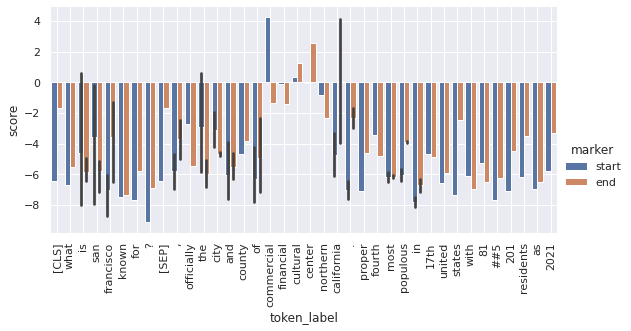

In [46]:
g = sns.catplot(x="token_label", y="score", hue="Type", data=df,
                kind="bar", height=4, aspect=2)

g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
g.ax.grid(True)
